In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/home/kirillmouraviev/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. Загрузка данных

Загрузим данные о поездках желтого такси с января 2015 по май 2016 из ячейки 1282 (находится на Манхэттене)

In [2]:
my_cell = 1282

In [3]:
def with_0(x):
    s = str(x)
    if len(s) == 1:
        s = '0' + s
    return s

In [4]:
def read_data(year, month):
    str_month = with_0(month)
    data = pd.read_csv('Data/Prepared/yellow_tripdata_' + str(year) + '-' + str_month + '_agregated.csv')
    my_data = data[data.cell == my_cell][['time', 'num_trips']]
    print(my_data.shape)
    return my_data

In [5]:
%%time
trips_by_months = []
for month in range(1, 13):
    trips_by_months.append(read_data(2015, month))
for month in range(1, 6):
    trips_by_months.append(read_data(2016, month))

(1415, 2)
(672, 2)
(744, 2)
(720, 2)
(744, 2)
(720, 2)
(744, 2)
(744, 2)
(720, 2)
(744, 2)
(720, 2)
(744, 2)
(744, 2)
(696, 2)
(744, 2)
(720, 2)
(744, 2)
CPU times: user 18.4 s, sys: 1.29 s, total: 19.7 s
Wall time: 23.5 s


В данных за январь 2015 года почему-то оказались данные за февраль. Почистим от них:

In [6]:
def clean(df):
    val = df.values
    val = np.array([x for x in val if x[0][6] == '1'])
    new_df = pd.DataFrame(val)
    new_df.columns = ['time', 'num_trips']
    return new_df

In [7]:
trips_by_months[0] = clean(trips_by_months[0])
print(trips_by_months[0].shape)

(743, 2)


In [8]:
trips_by_months[0].head()

,time,num_trips
0,2015-01-16 09,996
1,2015-01-26 05,117
2,2015-01-11 13,1182
3,2015-01-04 00,638
4,2015-01-23 11,1409


В предобработанных данных оказалось на один час меньше, чем нужно. Найдем, какой час отсутствует, и дополним его часом с предыдущих суток. От изменения одного значения из более чем 12000 вряд ли сильно изменится прогноз.

In [9]:
num_trips = [-1] * 744
for i in range(len(trips_by_months[0])):
    x = trips_by_months[0].loc[i][0]
    y = trips_by_months[0].loc[i][1]
    day = int(x[8:10])
    hour = int(x[11:13])
    num_trips[(day - 1) * 24 + hour] = y
absent_hour = num_trips.index(-1)
this_day = absent_hour // 24 + 1
this_hour = absent_hour % 24
trips_by_months[0].loc[len(trips_by_months[0])] = ['2015-01-' + with_0(this_day) + ' ' + with_0(this_hour),\
                                                   num_trips[absent_hour - 24]]
trips_by_months[0].tail()

,time,num_trips
739,2015-01-03 12,1357
740,2015-01-16 17,1516
741,2015-01-18 21,564
742,2015-01-16 15,1657
743,2015-01-27 04,78


Теперь сольем данные за все месяцы в один массив:

In [10]:
n_trips = []
for df in trips_by_months:
    df.sort_values(by='time', inplace=True)
    n_trips += list(df['num_trips'].values)
n_trips = np.array(n_trips)
print(n_trips.shape)

(12408,)


## 2. Регрессия

Создадим следующие массивы:
$$sw_i = \sin([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_week}); sy_i = \sin([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_year})$$ 
$$cw_i = \cos([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_week}), cy_i = \cos([1, \dots, T] * 2 \pi i\ /\ \text{hours_in_year}), i = 1, \dots, K$$
Сначала возьмем К равным 4

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
hours_in_week = 168
hours_in_year = 8766

In [13]:
def regression_residual(time_series, K, draw_plot=False):
    rng = np.arange(len(n_trips))
    X = []
    for i in range(K):
        X.append(np.sin(rng * 2 * np.pi  * (i + 1) / hours_in_week))
        X.append(np.cos(rng * 2 * np.pi  * (i + 1) / hours_in_week))
        X.append(np.sin(rng * 2 * np.pi  * (i + 1) / hours_in_year))
        X.append(np.cos(rng * 2 * np.pi  * (i + 1) / hours_in_year))
    X = np.array(X).T
    LR = LinearRegression()
    LR.fit(X, n_trips)
    residual = time_series - LR.predict(X)
    if draw_plot:
        plt.figure(figsize=(15, 7))
        beg = 5555
        plt.plot(LR.predict(X)[beg:beg + 720], label='Prediction', color='r')
        plt.plot(time_series[beg:beg + 720], label='Real data', color='b')
        plt.legend()
        plt.show()
    return (X, residual)

In [14]:
X, n_trips_residual = regression_residual(n_trips, 4)

Нарисуем график остатков регрессии за февраль и за весь период

In [15]:
def plot_residual(x):
    plt.figure(figsize=(20, 5))
    beg = 3333
    plt.plot(x[beg:beg + 720])
    plt.hlines(0, 0, 720, color='r')
    plt.title('Month')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(x, alpha=0.7)
    plt.hlines(0, 0, len(x), color='r')
    plt.title('Whole period', fontsize=16)
    plt.show()

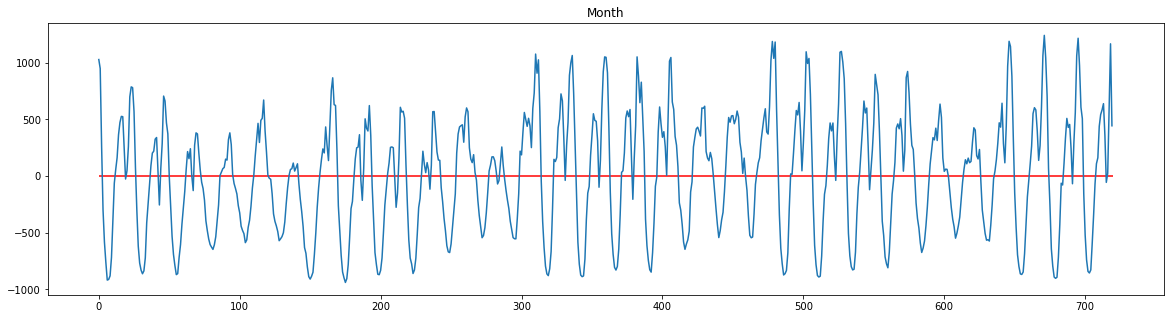

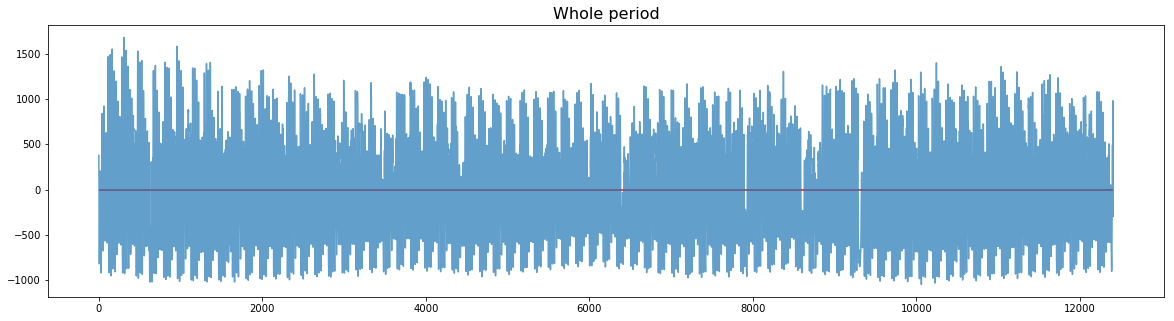

In [16]:
plot_residual(n_trips_residual)

При К=4 недельная сезонность осталась.

## 3. Модель ARIMA

Продифференцируем временной ряд сначала с шагом сутки, потом с шагом час. Построим графики продифференцированного ряда за весь период и за месяц

In [17]:
def diff_series(x, k, draw_plot=True):
    res = x[k:] - x[:-k]
    if draw_plot:
        plot_residual(res)
    return res

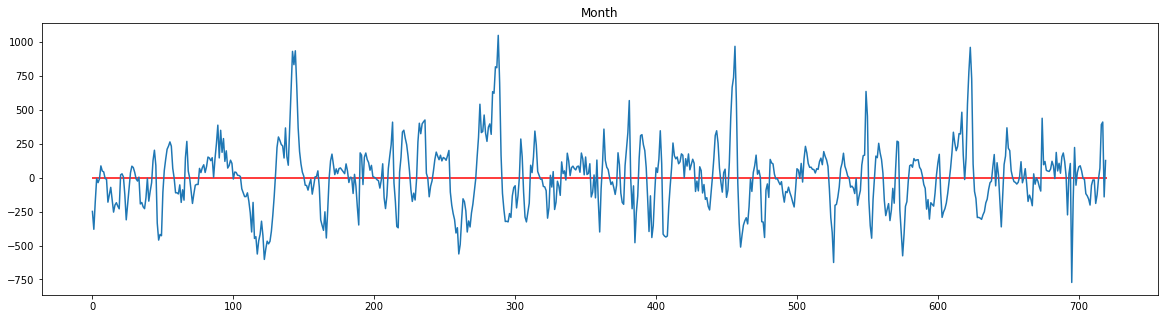

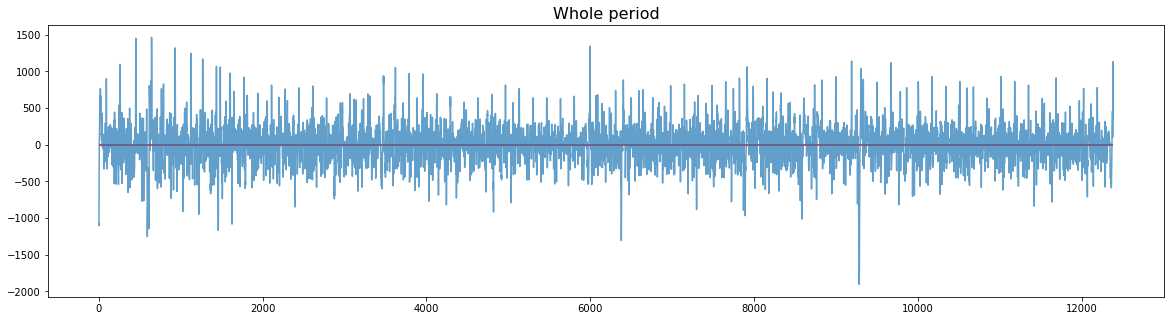

In [18]:
D1 = diff_series(n_trips_residual, 24)

Недельная сезонность осталась. Попробуем продифференцировать еще раз.

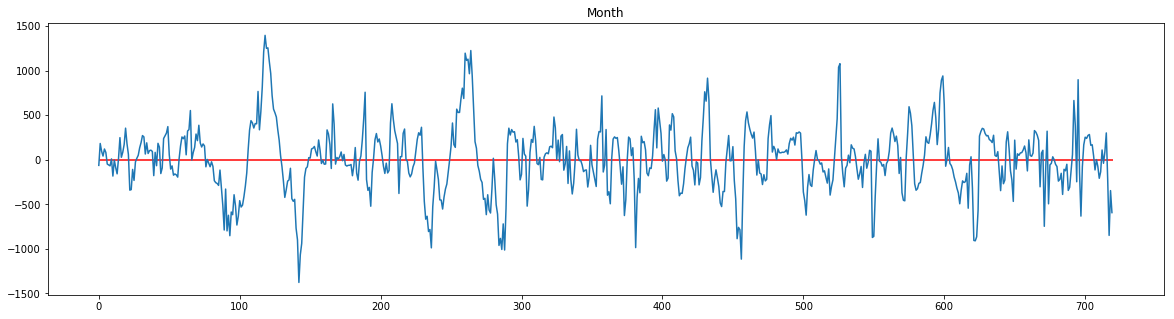

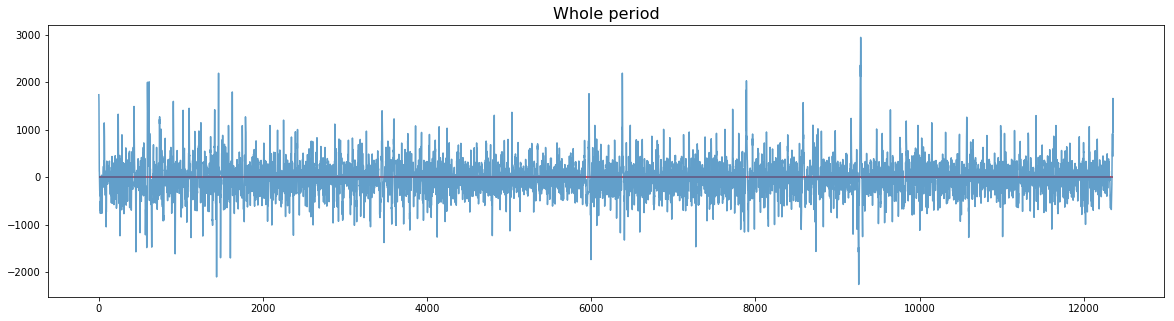

In [19]:
D2 = diff_series(D1, 24)

Теперь продифференцируем ряд с шагом 1:

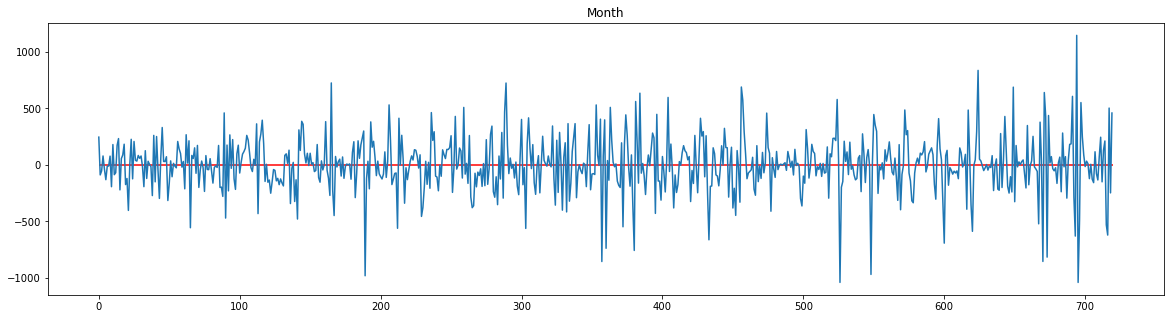

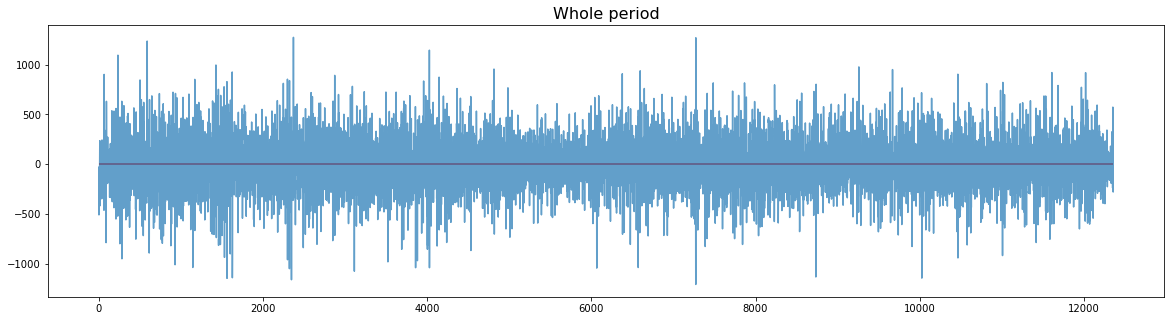

In [20]:
D3 = diff_series(D2, 1)

Ряд уже немного похож на стационарный. Посмотрим на его STL - декомпозицию и STL - декомпозицию исходного ряда:

In [21]:
import statsmodels.tsa.seasonal as sts

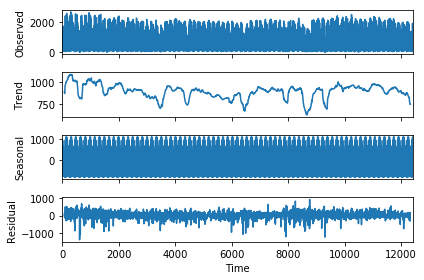

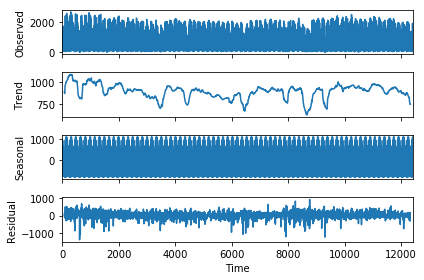

In [22]:
sts.seasonal_decompose(n_trips, freq=hours_in_week).plot()

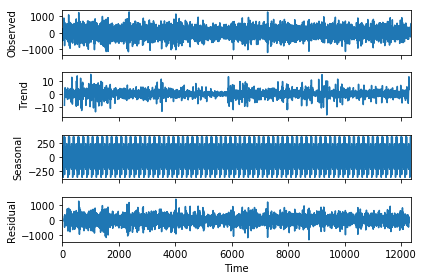

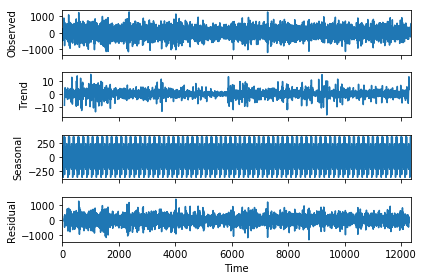

In [23]:
STL_decomposition = sts.seasonal_decompose(D3, freq=hours_in_week)
STL_decomposition.plot()

Недельная сеознность имеет размах в 4 раза меньше, чем в исходном ряде. Уже неплохо.

Построим графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) продифференцированного ряда (с лагом до года, до недели и до суток, чтобы определить, какие максимальные значения гиперпараметров модели p, q, P, Q надо брать)

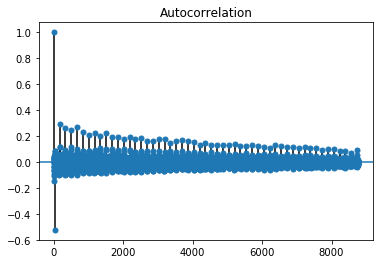

In [24]:
sm.graphics.tsa.plot_acf(D3, lags=hours_in_year, alpha=0.05)
plt.show()

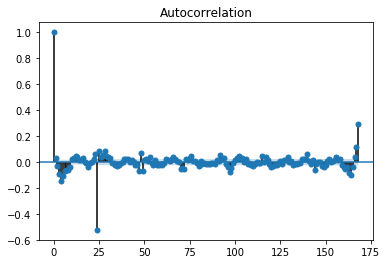

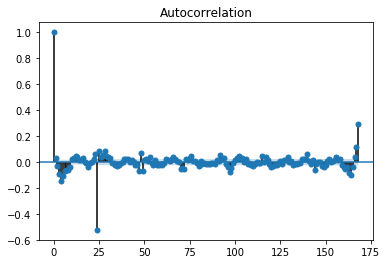

In [25]:
sm.graphics.tsa.plot_acf(D3, lags=hours_in_week, alpha=0.05)

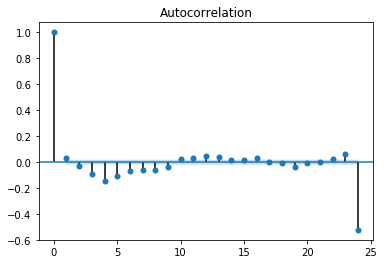

In [26]:
sm.graphics.tsa.plot_acf(D3, lags=24, alpha=0.05)
plt.show()

Частичная автокорреляция считается с квадратичной сложностью и для лага в 1 год будет строиться очень долго, поэтому нарисуем ее с лагом, равным 1 неделе.

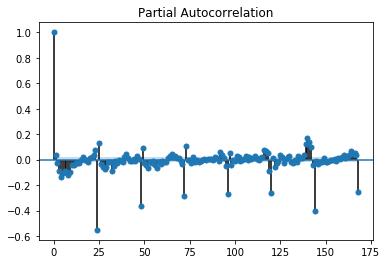

CPU times: user 1.32 s, sys: 792 ms, total: 2.11 s
Wall time: 1.23 s


In [27]:
%%time
sm.graphics.tsa.plot_pacf(D3, lags=168)
plt.show()

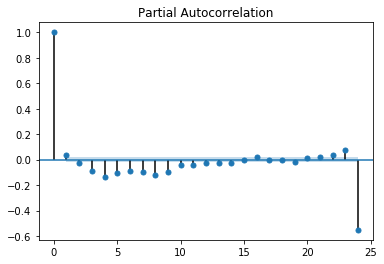

In [28]:
sm.tsa.graphics.plot_pacf(D3, lags=24)
plt.show()

Попробуем модель ARIMA на исходных данных с параметрами d=1, D=2, и параметрами p <= 4, P <= 6, q <= 4, Q <= 7

In [29]:
import statsmodels

In [30]:
%%time
ыещы
for p in range(1, 5):
    for P in range(1, 7):
        for q in range(5):
            for Q in range(8):
                sarimax = sm.tsa.statespace.SARIMAX(n_trips, X, order=(p, 1, q), seasonal_order=(P, 2, Q, 24), simple_differencing=True)
                res = sarimax.fit(disp=False)
                print(res.aic)
                break
            break
        break
    break

NameError: name 'ыещы' is not defined

In [ ]:
%%time
p = 4
q = 6
P = 4
Q = 7
sarimax = sm.tsa.statespace.SARIMAX(n_trips, exog=X, order=(p, 1, q), seasonal_order=(P, 2, Q, 24), simple_differencing=True)
res = sarimax.fit(disp=False)
print(res.aic)